# Разработка A/B-тестирования и анализ результатов

## Описание данных

Данные таблиц:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных

In [1]:
import pandas as pd

In [2]:
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

In [3]:
sessions_history.head(5)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [4]:
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


Таблица с историческими данными `sessions_history` содержит информацию о поведении пользователей примерно за 5 недель и состоит из 435 924 строк и 10 колонок. NULL-значения отсутствуют. Типы данных опеределены в основном корректно, проблема только с распознаванием дат. Исправим это.

In [5]:
sessions_history['session_start_ts'] = pd.to_datetime(sessions_history['session_start_ts'])
sessions_history['session_date'] = pd.to_datetime(sessions_history['session_date'], format = '%Y-%m-%d')

In [6]:
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   user_id            435924 non-null  object        
 1   session_id         435924 non-null  object        
 2   session_date       435924 non-null  datetime64[ns]
 3   session_start_ts   435924 non-null  datetime64[ns]
 4   install_date       435924 non-null  object        
 5   session_number     435924 non-null  int64         
 6   registration_flag  435924 non-null  int64         
 7   page_counter       435924 non-null  int64         
 8   region             435924 non-null  object        
 9   device             435924 non-null  object        
dtypes: datetime64[ns](2), int64(3), object(5)
memory usage: 33.3+ MB


#### 1.2. Знакомство с данными


Выведем топ пользователей по числу сессий.

In [7]:
sessions_history.groupby('user_id')['session_id'].nunique().sort_values(ascending=False)

user_id
10E0DEFC1ABDBBE0    10
6A73CB5566BB494D    10
8A60431A825D035B     9
D11541BAC141FB94     9
5BCFE7C4DCC148E9     9
                    ..
1DF13BB1953B3497     1
628502A3CE7E0A3C     1
1DEEF40DEFBD0C65     1
AC08479B7472C628     1
8A0882B6715D9EE5     1
Name: session_id, Length: 134039, dtype: int64

In [8]:
sessions_history.loc[sessions_history['user_id'] == sessions_history.groupby('user_id')['session_id'].count().idxmax()]

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


Как видно по выведенным сессиям одного пользователя, в таблице содержатся данные о:   
 - всех уникальных сессиях
 - дате и времени сессий
 - порядковом номере сессии
 - числе просмотренных страниц
 - регионе, где была проведена сессия
 - устройстве, с которого была проведена сессия
    

#### 1.3. Анализ числа регистраций

In [9]:
# Группируем данные

sh_gr_unique = sessions_history.groupby('session_date')['user_id'].nunique().reset_index()
sh_gr_reg = sessions_history.loc[sessions_history['registration_flag'] == 1].groupby('session_date')['user_id'].nunique().reset_index()

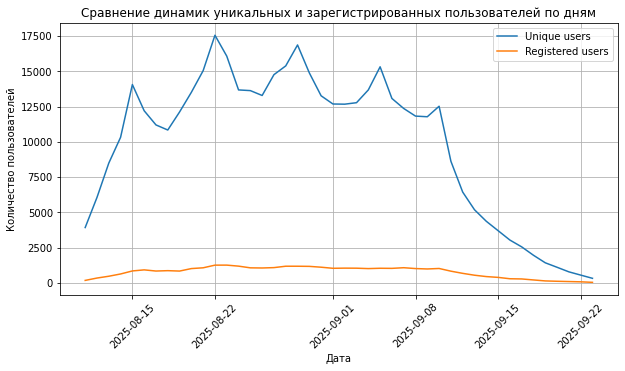

In [10]:
import matplotlib.pyplot as plt

x = sh_gr_unique.session_date.unique()
y_u = sh_gr_unique['user_id']
y_r = sh_gr_reg['user_id']

plt.figure(figsize=(10, 5))
plt.plot(x, y_u, label ='Unique users')
plt.plot(x, y_r, label ='Registered users')

plt.xticks(rotation=45)
plt.grid()

plt.xlabel("Дата")
plt.ylabel("Количество пользователей")
plt.legend()
plt.title('Сравнение динамик уникальных и зарегистрированных пользователей по дням')
plt.show()

In [11]:
# Вычисляем долю зарегистрированных пользователей по дням
x = sh_gr_unique.session_date.unique()
y_prop = y_r/y_u

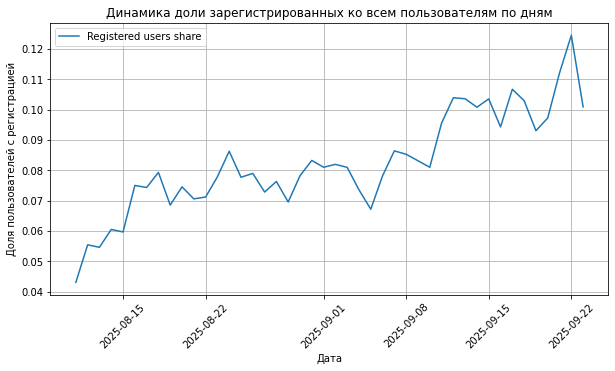

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(x, y_prop, label ='Registered users share')

plt.xticks(rotation=45)
plt.grid()

plt.xlabel("Дата")
plt.ylabel("Доля пользователей с регистрацией")
plt.legend()
plt.title('Динамика доли зарегистрированных ко всем пользователям по дням')
plt.show()

По построенным графикам с динамикой абсолютного числа уникальных пользователей по дням и когортам (все/зарегистрированные), а также с динамикой доли зарегистрированных пользователей по дням видно, что:
    
  - Число зарегистрированных пользователей сравнительно мало относительно всех пользователей
  - В начале августа число уникальных и зарегистрированных пользователей растет
  - Далее до 10-х чисел сентября число уникальных зарегистрированных пользователей остается довольно стабильное, в то время как у числа уникальных пользователей наблюдается флуктуации - оно колеблется от ~1100 до 1750 пользователей в день. Локальный максимум достигается 22 августа. Верноятно, это какая-то сезонная компонента
  - Примерно с 10-х чисел сентября наблюдается довольно резкое снижение числа уникальных пользователей приложения, для зарегистрированных пользователей это снижение выражено менее ярко
  - Снижение числа пользователей из предыдущего пункта сказывается на динамике доли зарегистрированных пользователей. Если в начале исторического периода оно было около 4%, далее колебалось от 6 до 8%, то в период снижения числа уникальных пользователей достигло 11%

#### 1.4. Анализ числа просмотренных страниц

In [13]:
sh_gr_pages = sessions_history.groupby('page_counter')['session_id'].nunique().reset_index()
print(sh_gr_pages)

   page_counter  session_id
0             1       29160
1             2      105536
2             3      166690
3             4      105569
4             5       26288
5             6        2589
6             7          92


<AxesSubplot:title={'center':'Сколько страниц просматривают за сессию'}, xlabel='Число страниц', ylabel='Количество сессий'>

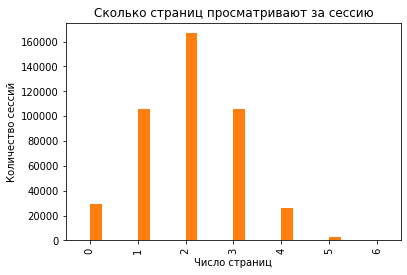

In [14]:
sh_gr_pages.plot(kind = 'bar',
                 title = 'Сколько страниц просматривают за сессию',
                 legend = False,
                 xlabel = 'Число страниц',
                 ylabel = 'Количество сессий'
)

#### 1.5. Доля пользователей, просмотревших более четырёх страниц

In [15]:
# Добавляем столбец good_session
sessions_history['good_session'] = sessions_history['page_counter'] >= 4
sessions_history['good_session'] = sessions_history['good_session'].astype('int8')
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,good_session
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone,0
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android,1
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC,1
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android,1
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android,0


<AxesSubplot:title={'center':'Динамика доли успешных сессий по дням'}, xlabel='Дата', ylabel='Доля успешных сессий'>

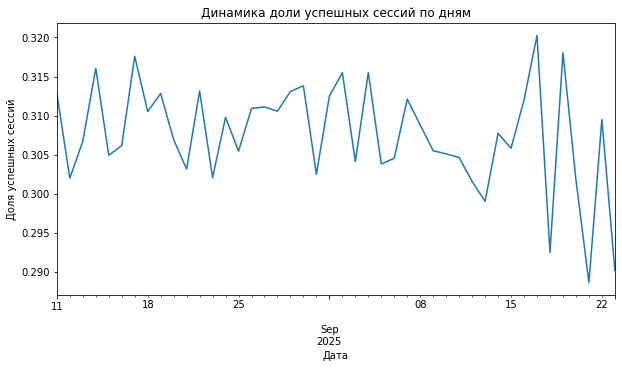

In [16]:
plt.figure(figsize=(10, 5))

succ_pages = sessions_history.groupby('session_date')['good_session'].mean()
succ_pages.plot(kind = 'line',
                 title = 'Динамика доли успешных сессий по дням',
                 legend = False,
                 xlabel = 'Дата',
                 ylabel = 'Доля успешных сессий'                                  
)

### 2. Подготовка к тесту

#### 2.1. Расчёт размера выборки

In [17]:
from statsmodels.stats.power import NormalIndPower

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### 2.1. Расчёт длительности A/B-теста

In [18]:
from math import ceil

# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = sessions_history.groupby('session_date')['user_id'].nunique().mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size*2/avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.363636363636 пользователей в день составит 4 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

In [19]:
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

In [20]:
sessions_test_part.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [21]:
sessions_test_part.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3130 entries, 0 to 3129
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            3130 non-null   object
 1   session_id         3130 non-null   object
 2   session_date       3130 non-null   object
 3   session_start_ts   3130 non-null   object
 4   install_date       3130 non-null   object
 5   session_number     3130 non-null   int64 
 6   registration_flag  3130 non-null   int64 
 7   page_counter       3130 non-null   int64 
 8   region             3130 non-null   object
 9   device             3130 non-null   object
 10  test_group         3130 non-null   object
dtypes: int64(3), object(8)
memory usage: 269.1+ KB


Таблица `sessions_test_part` не содержит пропусков, числовые данные распознаны корректно.

In [22]:
sessions_test_part['session_date'].unique()

array(['2025-10-14'], dtype=object)

Столбец `session_date` содержит данные об одной тестовой дате.

In [23]:
sessions_test_part_groups_shares = sessions_test_part.groupby('test_group')['user_id'].nunique()

In [24]:
st_part_groups_shares_for_diff = sessions_test_part_groups_shares.reset_index()
st_part_groups_shares_for_diff = round(abs(st_part_groups_shares_for_diff.iloc[1,1]-st_part_groups_shares_for_diff.iloc[0,1])/st_part_groups_shares_for_diff.iloc[0,1]*100,2)
print(f'Процентная разница в количестве пользователей в группах A и B составляет {st_part_groups_shares_for_diff}%.')

Процентная разница в количестве пользователей в группах A и B составляет 0.74%.


Выведем на графике соотношение групп. 
Группа А составляет `50,2%`, группа В `49,81%`. Группы сопоставимы, что видно и наглядно.

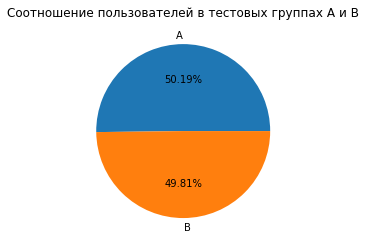

In [25]:
sessions_test_part_groups_shares.plot(
    kind= 'pie',
    title='Соотношение пользователей в тестовых группах А и В',
    autopct= '%.2f%%',
    ylabel= ''
)

plt.show()

#### 3.2. Проверка пересечений пользователей

In [26]:
groups_check = sessions_test_part.groupby('user_id')['test_group'].nunique().reset_index()
intersection = groups_check['user_id'].loc[groups_check['test_group'] > 1].count()
print(f'Количество пересечений между группами А и В: {intersection}')

Количество пересечений между группами А и В: 0


Следовательно, никаких пользователей исключать не нужно.

#### 3.3. Равномерность разделения пользователей по устройствам


In [27]:
# Разобьем данные по группам
gr_a = sessions_test_part.loc[sessions_test_part['test_group'] == 'A']
gr_b = sessions_test_part.loc[sessions_test_part['test_group'] == 'B']

In [28]:
# Сгруппируем данные по уникальному пользователю и девайсу
gr_a_device = gr_a.groupby(['user_id','device'])['session_id'].nunique().reset_index()
gr_b_device = gr_b.groupby(['user_id','device'])['session_id'].nunique().reset_index()

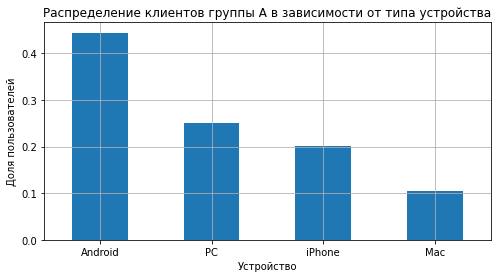

In [29]:
plt.figure(figsize=(8, 4))

gr_a_device['device'].value_counts(normalize=True).plot(
               kind='bar',
               rot=0, 
               legend=False,
               title=f'Распределение клиентов группы A в зависимости от типа устройства'
)

plt.xlabel('Устройство')
plt.ylabel('Доля пользователей')
plt.grid()

plt.show()

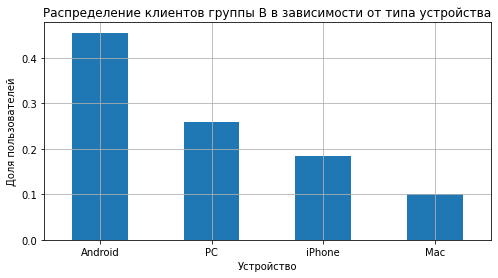

In [30]:
plt.figure(figsize=(8, 4))

gr_b_device['device'].value_counts(normalize=True).plot(
               kind='bar',
               rot=0,
               legend=False,
               title=f'Распределение клиентов группы B в зависимости от типа устройства'
)

plt.xlabel('Устройство')
plt.ylabel('Доля пользователей')
plt.grid()

plt.show()

Как видно по построенным графикам, распределение уникальных сессий пользователей по устройствам выглядит очень похоже в относительных величинах. Порядок и пропорции приблизительно похожи. Необходимости корректировать группы нет.

#### 3.4. Равномерность распределения пользователей по регионам

In [31]:
# Сгруппируем данные по уникальному пользователю и региону
gr_a_region = gr_a.groupby(['user_id','region'])['session_id'].nunique().reset_index()
gr_b_region = gr_b.groupby(['user_id','region'])['session_id'].nunique().reset_index()

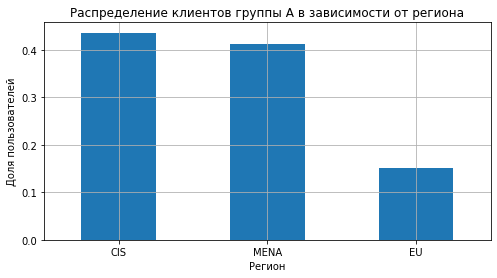

In [32]:
plt.figure(figsize=(8, 4))

gr_a_region['region'].value_counts(normalize=True).plot(
               kind='bar',
               rot=0, 
               legend=False,
               title=f'Распределение клиентов группы A в зависимости от региона'
)

plt.xlabel('Регион')
plt.ylabel('Доля пользователей')
plt.grid()

plt.show()

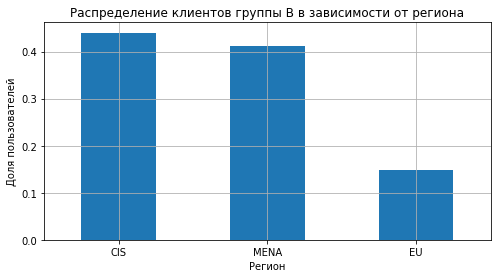

In [33]:
plt.figure(figsize=(8, 4))

gr_b_region['region'].value_counts(normalize=True).plot(
               kind='bar',
               rot=0, 
               legend=False,
               title=f'Распределение клиентов группы B в зависимости от региона'
)

plt.xlabel('Регион')
plt.ylabel('Доля пользователей')
plt.grid()

plt.show()

Аналогично пункту 3.3 распределение уникальных сессий пользователей по регионам выглядит сопоставимо. Необходимости корректировать группы нет.

#### 3.5. Вывод после проверки A/B-теста

Как можно понять по проведенным исследованиям, группы сопоставимы по следующим признакам:
 - Количество пользователей в группах отличается незначительно, в рамках допустимой погрешности. Различие составляет 0,7%
 - Выборки являются независимыми, т.к. пересечений по пользователям не наблюдается
 - Распределение данных тестовой и контрольной групп по типам устройств, а также по регионам схожи и подтверждают возможность дальнейшего проведения A/B теста.

### 4. Проверка результатов A/B-теста

#### 4.1. Получение результатов теста и подсчёт основной метрики

In [34]:
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

In [35]:
# Добавляем столбец
sessions_test['good_session'] = sessions_test['page_counter'] >= 4
sessions_test['good_session'] = sessions_test['good_session'].astype('int8')
sessions_test.tail()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
100000,CF77C27B238C1BE3,0F7BC9B33685377C,2025-10-22,2025-10-22 19:01:50,2025-10-20,3,0,3,MENA,Android,A,0
100001,D7ED66C581409AC2,26C4475005E70F47,2025-10-17,2025-10-17 22:12:38,2025-10-17,1,0,5,CIS,PC,A,1
100002,E7EA2D51238020C6,9B9CDE6A612CBD73,2025-10-24,2025-10-24 14:54:07,2025-10-14,2,0,3,MENA,PC,B,0
100003,8A6FEFD7F34C5DA1,37291EC27106EF9D,2025-10-18,2025-10-18 00:05:10,2025-10-14,3,0,4,EU,Android,B,1
100004,EE2CA3C8481A0DE8,A4C833633CD4412E,2025-10-23,2025-10-23 10:02:27,2025-10-19,2,0,2,MENA,Android,B,0


In [36]:
#Сроки проведения теста

sessions_test['session_date'] = pd.to_datetime(sessions_test['session_date'], format = '%Y-%m-%d')
dates = sessions_test['session_date'].unique()
dt_index = pd.DatetimeIndex(dates)
dt_index.sort_values()

DatetimeIndex(['2025-10-14', '2025-10-15', '2025-10-16', '2025-10-17',
               '2025-10-18', '2025-10-19', '2025-10-20', '2025-10-21',
               '2025-10-22', '2025-10-23', '2025-10-24', '2025-10-25',
               '2025-10-26', '2025-10-27', '2025-10-28', '2025-10-29',
               '2025-10-30', '2025-10-31', '2025-11-01', '2025-11-02'],
              dtype='datetime64[ns]', freq=None)

In [37]:
#Число пользователей

sessions_test.groupby('test_group')['user_id'].nunique()

test_group
A    15163
B    15416
Name: user_id, dtype: int64

#### 4.2. Проверка корректности результатов теста

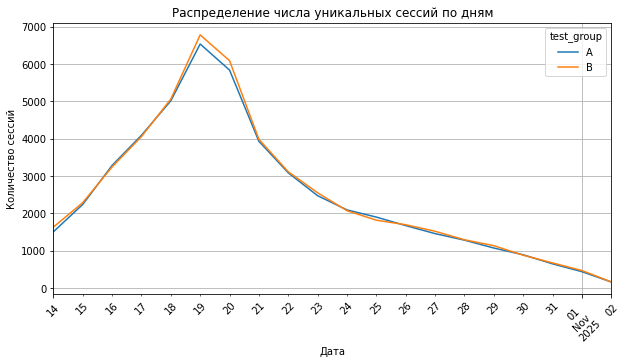

In [38]:
grouped = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().unstack(fill_value=0)

grouped.plot(kind='line',
               title=f'Распределение числа уникальных сессий по дням',
               legend=True,
               ylabel='Количество сессий',
               xlabel='Дата',
               rot=45,
               figsize=(10, 5))
plt.grid()

plt.show()

Как видно по построенному графику с распределением числа уникальных сессий по дням, динамики для тестовой и контрольной группы очень схожи и имеют минимум отклонений.  
Подтвердим это с помощью статистического теста. Использовать будем `тест Стьюдента`, т.к. нужно сделать вывод о равенстве средних двух выборок.

Сформулируем гипотезу:
 - `H0` - средние количества уникальных сессий по дням для групп **А** и **В** не отличаются
 - `H1` - среднее количество уникальных сессий по дням для группы **В** больше или меньше, чем для группы **А**
 

In [39]:
from scipy.stats import ttest_ind

metric_a = grouped.reset_index()['A'] ## выборка целевой метрики для группы A
metric_b = grouped.reset_index()['B'] ## выборка целевой метрики для группы B

alpha = 0.05 ## на каком уровне значимости проверяем гипотезу о равенстве выборочных средних
stat_ttest, p_value_ttest = ttest_ind(
    metric_a, 
    metric_b, 
    alternative='two-sided' ## поскольку альтернативная гипотеза о том, что выборочное среднее первой выборки(metric_a) меньше второй выборки
) ## применяем тест Стьюдента (классический T-test)

if p_value_ttest>alpha:
    print(f'p-value теста Стьюдента = {round(p_value_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны')
else:
    print(f'p-value теста Стьюдента ={round(p_value_ttest, 2)}')
    print('Нулевая гипотеза не находит подтверждения! Выборочные средние в группах A и B не равны, и в группе B больше')

p-value теста Стьюдента = 0.94
Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны


По итогам теста принимаем нулевую гипотезу о равенстве средних и проводим A/B тест дальше.

#### 4.3. Сравнение доли успешных сессий

In [40]:
delta_prop = sessions_test.groupby('test_group')['good_session'].mean().reset_index()
print(delta_prop)

  test_group  good_session
0          A      0.307723
1          B      0.318290


In [41]:
delta = delta_prop['good_session'].max() - delta_prop['good_session'].min()
print(f'Доля успешных сессий в группе B больше чем в группе A на {round(delta*100,1)}%')

Доля успешных сессий в группе B больше чем в группе A на 1.1%


#### 4.4. Насколько статистически значимо изменение ключевой метрики

Подтвердим или опровергнем вывод из пункта 4.3. Для этого проведем проверку с помощью `Z-теста пропорций`, который позволяет определить, существует ли разницы в долях для независимых групп.

Сформулируем гипотезу:
 - `H0` - вероятности успеха (в данном случае просмотра 4-х и более страниц) для групп **А** и **В** равны `или` вероятность успеха для группы **В** *меньше*, чем для группы **А**
 - `H1` - вероятность успеха для группы **В** больше, чем для группы **А**
 

In [42]:
from statsmodels.stats.proportion import proportions_ztest

metric_a_sess = sessions_test['good_session'].loc[sessions_test['test_group']=='A']
metric_b_sess = sessions_test['good_session'].loc[sessions_test['test_group']=='B']

n_a = metric_a_sess.shape[0]
n_b = metric_b_sess.shape[0]
m_a = metric_a_sess.sum()
m_b = metric_b_sess.sum()

alpha = 0.05 ## на каком уровне значимости проверяем гипотезу о равенстве вероятностей

stat_ztest, p_value_ztest = proportions_ztest(
    [m_b, m_a],
    [n_b, n_a],
    alternative='larger'
)

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=0.0001574739988036123 < 0.05
Нулевая гипотеза не находит подтверждения!


#### 4.5. Вывод по результатам A/B-эксперимента

Эксперимент проводился с `14 октября` по `2 ноября` (20 дней) с участием `15 163` пользователей в контрольной группе (**A**) и `15 416` пользователей в тестовой группе (**B**).

Внедрение нового алгоритма рекомендаций привело ***к росту ключевой метрики (доли успешных сессий)*** на `1.1%` в группе B по сравнению с группой A. Значимость этого изменения подтверждена Z-тестом пропорций. P-value (`0.00016`) значительно ниже стандартного уровня значимости (`0.05`), что свидетельствует о статистически значимом эффекте от изменений.

**Рекомендация:** Учитывая положительное влияние на метрику и высокую статистическую значимость, целесообразно внедрить новый алгоритм рекомендаций в приложение. Однако перед полным запуском стоит проверить, не оказал ли алгоритм негативного влияния на другие важные показатели (например, retention, среднее время сессии и т. д.).